In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import calendar
import concurrent.futures

### Extract sensor ids of interest

In [2]:
response = requests.get("https://data.sensor.community/airrohr/v1/filter/country=DE,AT&type=SDS011")
sensors_dict = json.loads(response.content.decode('utf-8'))

In [4]:
sensors_of_interest = [{"sensor_id": sensor_measurement["sensor"]["id"], 
                        "lon": sensor_measurement["location"]["longitude"], 
                        "lat": sensor_measurement["location"]["latitude"]} for sensor_measurement in sensors_dict]
sensors_df = pd.DataFrame(sensors_of_interest)

In [5]:
sensors_df.to_csv("/mnt/data/processed/sensor_community_ids_de_at_sds011.csv")
# clipping to aoi is done in QGIS

### Extracting archive values for sensors of interest

In [95]:
def generate_urls(year: int, sensor_id: int, sensor_type: str = "sds011"):
    urls = []
    suffix = "csv" if year in [2021, 2022] else "csv.gz"
    for month in range(1, 13):
        days_in_month = calendar.monthrange(year, month)[1]
        for day in range(1, days_in_month + 1):
            formatted_date = f"{year}-{month:02d}-{day:02d}"
            url = f"http://archive.sensor.community/{year}/{formatted_date}/{formatted_date}_{sensor_type}_sensor_{sensor_id}.{suffix}"
            urls.append(url)
    return urls

def process_sensor_data(url, sid):
    try:
        df = pd.read_csv(url, sep=";")
        lat = df.loc[0, "lat"]
        lon = df.loc[0, "lon"]
        p1_value = df["P1"].mean()
        p2_value = df["P2"].mean()
        date = url.split("/")[-2]
        return (date, p1_value, p2_value, lon, lat)
    except Exception as e:
        return None

In [96]:
sensors_of_interest_df  = pd.read_csv("/mnt/data/processed/Sensor_Community/sensor_community_ids_aoi_sds011.csv")

In [103]:
sensors_of_interest_sample_df = sensors_of_interest_df.sample(10, random_state=0)

In [98]:
data_dict = {}

for i, item in sensors_of_interest_sample_df.iterrows():
    sid = int(item["sensor_id"])
    url_list = generate_urls(2022, sid)
    data_dict[sid] = {}
    data_dict[sid]["values"] = []

    for url in url_list:
        result = process_sensor_data(url, sid)
        if result is not None:
            date, p1_value, p2_value, lon, lat = result
            data_dict[sid]["values"].append((date, p1_value, p2_value))
            data_dict[sid]["geometry"] = (lon, lat)

    break

No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available
No data available


In [99]:
data_dict

{21657: {'values': [('2022-01-01', 6.665052083333333, 2.917204861111111),
   ('2022-01-02', 7.694290718038528, 3.0042907180385288),
   ('2022-01-03', 2.441280701754386, 0.7344912280701754),
   ('2022-01-04', 1.0203152364273205, 0.5149211908931699),
   ('2022-01-05', 2.025130434782609, 0.6497391304347826),
   ('2022-01-06', 5.536155268022182, 2.1060998151571164),
   ('2022-01-07', 7.091438596491229, 2.8397192982456136),
   ('2022-01-08', 2.213193717277487, 1.0841012216404888),
   ('2022-01-09', 2.4338756855575867, 1.0412431444241315),
   ('2022-01-10', 8.794214162348878, 3.251692573402418),
   ('2022-01-11', 13.898248686514885, 4.9296322241681265),
   ('2022-01-12', 19.245323992994745, 6.571873905429071),
   ('2022-01-13', 43.15804232804233, 12.223597883597884),
   ('2022-01-14', 26.824638447971783, 8.662063492063492),
   ('2022-01-15', 34.76965201465202, 10.290549450549449),
   ('2022-01-16', 22.22686170212766, 7.626099290780141),
   ('2022-01-17', 7.3768495575221245, 2.907911504424778

In [101]:
df = pd.DataFrame(data_dict[21657]["values"], columns=["date", "PM10", "PM25"])
df.set_index("date", inplace=True)

<Axes: xlabel='date'>

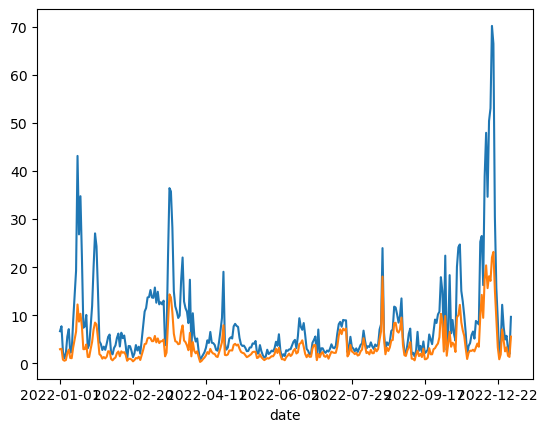

In [102]:
df["PM10"].plot()
df["PM25"].plot()

In [ ]:
import json

# Create a GeoJSON structure
geojson_data = {
    "type": "FeatureCollection",
    "features": []
}

for i, item in sensors_of_interest_sample_df.iterrows():
    sid = int(item["sensor_id"])
    url_list = generate_urls(2022, sid)
    feature = {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": []
        },
        "properties": {
            "sensor_id": sid,
            "values": []
        }
    }

    for url in url_list:
        result = process_sensor_data(url, sid)
        if result is not None:
            date, p1_value, p2_value, lon, lat = result
            feature["properties"]["values"].append((date, p1_value, p2_value))
            feature["geometry"]["coordinates"] = [lon, lat]

    geojson_data["features"].append(feature)

# Convert the GeoJSON data to a JSON string
geojson_string = json.dumps(geojson_data, indent=2)

# You can save the GeoJSON string to a file or use it as needed
with open("output.geojson", "w") as geojson_file:
    geojson_file.write(geojson_string)